In [1]:
%matplotlib inline
import os
if os.path.exists("myScripts/featureengineering.py"):
    os.remove("myScripts/featureengineering.py")

In [2]:
import pandas as pd
import numpy as np
import datetime
from sklearn.pipeline import Pipeline, FeatureUnion
from matplotlib import pyplot as plt
from functools import reduce
from sklearn import preprocessing

In [13]:
# Need to run once for mapping ip addresses in fraud transactions dataset to respective countries
#path='C:\\Users\\srika\\OneDrive\\Desktop\\Spring20\\DataScienceAssesmentNovelis\\analysis_df.csv'
#from myScripts.dataingestion import join_datasets
#analysis_df = join_datasets('Candidate_tech_evaluation_candidate_copy_data science_fraud.csv',
 #                            'Candidate_tech_evaluation_candidate_copy_datascience_IpAddress_to_Country.xlsx',path)

In [32]:
#analysis_df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,285108,7/15/2015 4:36,9/10/2015 14:17,31,HZAKVUFTDOSFD,Direct,Chrome,M,49,2.818400e+09,0,United States
1,131009,1/24/2015 12:29,4/13/2015 4:53,31,XGQAJSOUJIZCC,SEO,IE,F,21,3.251268e+09,0,United Kingdom
2,328855,3/11/2015 0:54,4/5/2015 12:23,16,VCCTAYDCWKZIY,Direct,IE,M,26,2.727760e+09,0,United States
3,229053,1/7/2015 13:19,1/9/2015 10:12,29,MFFIHYNXCJLEY,SEO,Chrome,M,34,2.083420e+09,0,Korea Republic of
4,108439,2/8/2015 21:11,4/9/2015 14:26,26,WMSXWGVPNIFBM,Ads,FireFox,M,33,3.207913e+09,0,Brazil


In [3]:
%%writefile myScripts/featureengineering.py -a
import pandas as pd
import numpy as np
import datetime

from matplotlib import pyplot as plt
from functools import reduce
from sklearn import preprocessing
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base  import BaseEstimator,TransformerMixin
### Calculate ratio of fraudulent transaction by each categorical variable

class MultiColumnLabelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = preprocessing.LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = preprocessing.LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)
class CalculateRatioFraud(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key=key
    def fit(self, X, y=None):
        return self
    def transform(self,X):
        tmp = X.groupby([self.key, 'class']).user_id.nunique()\
        .unstack(level = 1)\
        .reset_index()\
        .rename(columns = {0:'Not Fraud', 1: 'Fraud'}).fillna(0.0)
        tmp['ratio_fraud_' + self.key] = tmp['Fraud']/(tmp['Fraud'] + tmp['Not Fraud'])
        tmp['num_trans_' + self.key] = tmp['Fraud'] + tmp['Not Fraud']
        return X[['user_id', self.key]]\
                .merge(tmp[[self.key, 'ratio_fraud_' + self.key, 'num_trans_' + self.key]], on = self.key)

class CalculateTimeLatency(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        X['time_latency']=(X.purchase_time-X.signup_time).dt.total_seconds()/60/60
        return X

class MergeMultipleDataframes(BaseEstimator, TransformerMixin):
    def __init__(self,dfs,key,method):
        self.dfs=dfs
        self.key=key
        self.method=method
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        Xunion=reduce(lambda  left, right: pd.merge(left, right, on = self.key, how=self.method), self.dfs)
        return Xunion
        
class ApplyLabelEncoding(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        return MultiColumnLabelEncoder(columns = X.columns).fit_transform(X)

    
class CreateFeatures(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        X.signup_time=pd.to_datetime(X.signup_time, format = '%m/%d/%Y %H:%M')
        X.purchase_time=pd.to_datetime(X.purchase_time, format = '%m/%d/%Y %H:%M')
        X = X.fillna('NA')
        fraud_by_dev = CalculateRatioFraud(key='device_id').transform(X)
        fraud_by_country = CalculateRatioFraud(key='country').transform(X)
        fraud_by_age = CalculateRatioFraud(key='age').transform(X)
        fraud_by_gender = CalculateRatioFraud(key='sex').transform(X)
        fraud_by_source = CalculateRatioFraud(key='source').transform(X)
        fraud_by_browser = CalculateRatioFraud(key='browser').transform(X)
        latency_df = CalculateTimeLatency().transform(X)
        feature_df = MergeMultipleDataframes(dfs=[
                                        fraud_by_dev, fraud_by_country, 
                                        fraud_by_gender, 
                                        fraud_by_age, 
                                        fraud_by_browser, 
                                        fraud_by_source, 
                                        X[['user_id', 'purchase_value', 'class']],
                                        latency_df[['user_id', 'time_latency']]
                                       ], 
                                       key = ['user_id'], method = 'outer').transform(X)
        df_cat = ApplyLabelEncoding().transform(feature_df[['country', 'sex', 'browser', 'source']])
        return pd.concat([feature_df.drop(['country', 'sex', 'browser', 'source'], axis = 1), df_cat], axis = 1).set_index(['user_id', 'device_id'])

Writing myScripts/featureengineering.py


In [12]:
from myScripts.featureengineering import CreateFeatures

In [13]:
custom_pipeline = Pipeline( steps = [('create_features', CreateFeatures())])

In [17]:
final_df=custom_pipeline.fit_transform(df)

In [18]:
final_df.head()

,,ratio_fraud_device_id,num_trans_device_id,ratio_fraud_country,num_trans_country,ratio_fraud_sex,num_trans_sex,age,ratio_fraud_age,num_trans_age,ratio_fraud_browser,num_trans_browser,ratio_fraud_source,num_trans_source,purchase_value,class,time_latency,country,sex,browser,source
user_id,device_id,,,,,,,,,,,,,,,,,,,,
285108,HZAKVUFTDOSFD,0.0,2.0,0.096830,46184.0,0.095442,70126,49,0.056534,1079.0,0.099441,48652,0.105643,24242,31,0,1377.683333,167,1,0,1
369076,HZAKVUFTDOSFD,0.0,2.0,0.115188,2344.0,0.095442,70126,43,0.084140,2686.0,0.091743,19620,0.091696,47461,40,0,1372.683333,30,1,4,0
131009,XGQAJSOUJIZCC,0.0,1.0,0.103911,3580.0,0.091671,49874,21,0.079291,2989.0,0.086107,29138,0.090109,48297,31,0,1888.400000,166,0,2,2
328855,VCCTAYDCWKZIY,0.0,1.0,0.096830,46184.0,0.095442,70126,26,0.076906,4460.0,0.086107,29138,0.105643,24242,16,0,611.483333,167,1,2,1
229053,MFFIHYNXCJLEY,0.0,1.0,0.091589,3341.0,0.095442,70126,34,0.088694,5006.0,0.099441,48652,0.090109,48297,29,0,44.883333,86,1,0,2


In [31]:
full_pipeline = FeatureUnion( transformer_list = [( 'custom_pipeline', custom_pipeline )])

In [32]:
original_dataset=full_pipeline.fit_transform(df)

In [35]:
original_dataset[:1]

array([[0.00000000e+00, 2.00000000e+00, 9.68300710e-02, 4.61840000e+04,
        9.54424892e-02, 7.01260000e+04, 4.90000000e+01, 5.65338276e-02,
        1.07900000e+03, 9.94409274e-02, 4.86520000e+04, 1.05643099e-01,
        2.42420000e+04, 3.10000000e+01, 0.00000000e+00, 1.37768333e+03,
        1.67000000e+02, 1.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [6]:
from myScripts import featureengineering
feature_df = featureengineering.CreateFeatures().transform(df)

In [7]:
feature_df.head()

,,ratio_fraud_device_id,num_trans_device_id,ratio_fraud_country,num_trans_country,ratio_fraud_sex,num_trans_sex,age,ratio_fraud_age,num_trans_age,ratio_fraud_browser,num_trans_browser,ratio_fraud_source,num_trans_source,purchase_value,class,time_latency,country,sex,browser,source
user_id,device_id,,,,,,,,,,,,,,,,,,,,
285108,HZAKVUFTDOSFD,0.0,2.0,0.096830,46184.0,0.095442,70126,49,0.056534,1079.0,0.099441,48652,0.105643,24242,31,0,1377.683333,167,1,0,1
369076,HZAKVUFTDOSFD,0.0,2.0,0.115188,2344.0,0.095442,70126,43,0.084140,2686.0,0.091743,19620,0.091696,47461,40,0,1372.683333,30,1,4,0
131009,XGQAJSOUJIZCC,0.0,1.0,0.103911,3580.0,0.091671,49874,21,0.079291,2989.0,0.086107,29138,0.090109,48297,31,0,1888.400000,166,0,2,2
328855,VCCTAYDCWKZIY,0.0,1.0,0.096830,46184.0,0.095442,70126,26,0.076906,4460.0,0.086107,29138,0.105643,24242,16,0,611.483333,167,1,2,1
229053,MFFIHYNXCJLEY,0.0,1.0,0.091589,3341.0,0.095442,70126,34,0.088694,5006.0,0.099441,48652,0.090109,48297,29,0,44.883333,86,1,0,2


In [15]:
df = pd.read_csv('Analysis_dataset.csv')\
.drop('Unnamed: 0', axis = 1)

In [16]:
df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,285108,7/15/2015 4:36,9/10/2015 14:17,31,HZAKVUFTDOSFD,Direct,Chrome,M,49,2.818400e+09,0,United States
1,131009,1/24/2015 12:29,4/13/2015 4:53,31,XGQAJSOUJIZCC,SEO,IE,F,21,3.251268e+09,0,United Kingdom
2,328855,3/11/2015 0:54,4/5/2015 12:23,16,VCCTAYDCWKZIY,Direct,IE,M,26,2.727760e+09,0,United States
3,229053,1/7/2015 13:19,1/9/2015 10:12,29,MFFIHYNXCJLEY,SEO,Chrome,M,34,2.083420e+09,0,Korea Republic of
4,108439,2/8/2015 21:11,4/9/2015 14:26,26,WMSXWGVPNIFBM,Ads,FireFox,M,33,3.207913e+09,0,Brazil


### Exploratory Data Analysis and feature engineering

In [11]:
## Datatypes
analysis_df.dtypes

user_id             int64
signup_time        object
purchase_time      object
purchase_value      int64
device_id          object
source             object
browser            object
sex                object
age                 int64
ip_address        float64
class               int64
country            object
dtype: object

In [12]:
## Convert signup and purchase times to pandas datatime
analysis_df.signup_time = pd.to_datetime(analysis_df.signup_time, format = '%m/%d/%Y %H:%M')
analysis_df.purchase_time = pd.to_datetime(analysis_df.purchase_time, format = '%m/%d/%Y %H:%M')

In [13]:
## Fill missing values with NA
analysis_df = analysis_df.fillna('NA')

#### Class imbalance

Text(0, 0.5, 'Number of transaction')

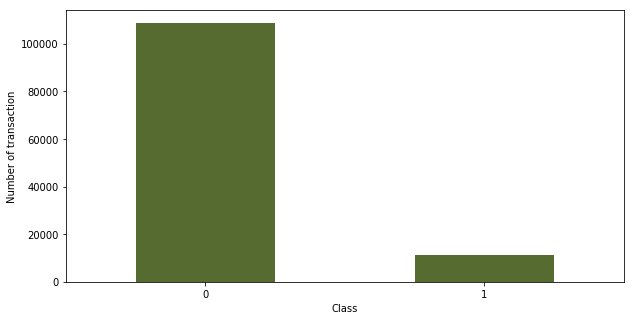

In [14]:
### Acknowledging class imbalance (number of fraudulent transaction is significantly higher than non-fraudulent transactions)
### We'll account for class imbalance later during modeling.

analysis_df['class'].value_counts()\
.plot(kind = 'bar', rot = 0, color = '#556B2F', figsize = (10, 5))
plt.xlabel('Class')
plt.ylabel('Number of transaction')

### Start creating feature dataframe

In [15]:
### Calculate ratio of fraudulent transaction by each categorical variable

def calculate_ratio_fraud(analysis_df, sel_var):
    tmp = analysis_df.groupby([sel_var, 'class']).user_id.nunique()\
    .unstack(level = 1)\
    .reset_index()\
    .rename(columns = {0:'Not Fraud', 1: 'Fraud'}).fillna(0.0)
    tmp['ratio_fraud_' + sel_var] = tmp['Fraud']/(tmp['Fraud'] + tmp['Not Fraud'])
    tmp['num_trans_' + sel_var] = tmp['Fraud'] + tmp['Not Fraud']
    return analysis_df[['user_id', sel_var, 'class']]\
            .merge(tmp[[sel_var, 'ratio_fraud_' + sel_var, 'num_trans_' + sel_var]], on = sel_var)

C:\Users\SubediS\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


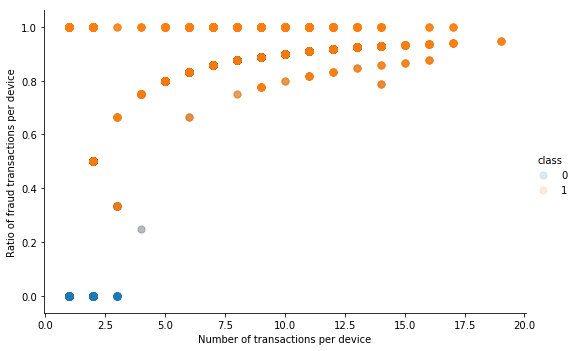

In [16]:
### Are some devices involved in significantly more fradulent transactions than others?
import seaborn as sns
fraud_by_dev = calculate_ratio_fraud(analysis_df, 'device_id')
fg = sns.FacetGrid(data=fraud_by_dev, hue='class', size = 5, aspect=1.5)
fg.map(plt.scatter, 'num_trans_device_id', 'ratio_fraud_device_id', alpha = 0.15, s = 50).add_legend()
plt.xlabel('Number of transactions per device')
plt.ylabel('Ratio of fraud transactions per device');

Clearly, devices involved in fraudulent transactions have more transactions (per device) than others, and also the ratio of fradulent transaction is significantly higher for them.

In [17]:
### Is there a clear difference among countries?
fraud_by_country = calculate_ratio_fraud(analysis_df, 'country')
fraud_by_country.groupby(['country'])['ratio_fraud_country', 'num_trans_country'].mean().reset_index()\
.sort_values(by = 'num_trans_country', ascending = False).head(20)

,country,ratio_fraud_country,num_trans_country
167,United States,0.096830,46184.0
113,NA,0.085142,17418.0
34,China,0.085711,9532.0
82,Japan,0.096600,5735.0
166,United Kingdom,0.103911,3580.0
86,Korea Republic of,0.091589,3341.0
62,Germany,0.073010,2890.0
58,France,0.093612,2489.0
23,Brazil,0.092648,2353.0
30,Canada,0.115188,2344.0


In [18]:
## Is there clear difference between gender?
fraud_by_gender = calculate_ratio_fraud(analysis_df, 'sex')
fraud_by_gender.sort_values(by = 'ratio_fraud_sex', ascending = False)\
.groupby('sex')['ratio_fraud_sex', 'num_trans_sex'].mean()

,ratio_fraud_sex,num_trans_sex
sex,,
F,0.091671,49874
M,0.095442,70126


In [19]:
## Is there clear difference between source?
fraud_by_source = calculate_ratio_fraud(analysis_df, 'source')
fraud_by_source.sort_values(by = 'ratio_fraud_source', ascending = False)\
.groupby('source')['ratio_fraud_source', 'num_trans_source'].mean()

,ratio_fraud_source,num_trans_source
source,,
Ads,0.091696,47461
Direct,0.105643,24242
SEO,0.090109,48297


In [20]:
## Is there clear difference between browser?
fraud_by_browser = calculate_ratio_fraud(analysis_df, 'browser')
fraud_by_browser.sort_values(by = 'ratio_fraud_browser', ascending = False)\
.groupby('browser')['ratio_fraud_browser', 'num_trans_browser'].mean()

,ratio_fraud_browser,num_trans_browser
browser,,
Chrome,0.099441,48652
FireFox,0.094112,19615
IE,0.086107,29138
Opera,0.091429,2975
Safari,0.091743,19620


In [21]:
## Is there clear difference between age?
fraud_by_age = calculate_ratio_fraud(analysis_df, 'age')
fraud_by_age.sort_values(by = 'ratio_fraud_age', ascending = False)\
.groupby('age')['ratio_fraud_age', 'num_trans_age'].mean().head(20)

,ratio_fraud_age,num_trans_age
age,,
18,0.097639,2202.0
19,0.086147,2310.0
20,0.089647,2666.0
21,0.079291,2989.0
22,0.092587,3251.0
23,0.108641,3599.0
24,0.100889,3935.0
25,0.078928,4143.0
26,0.076906,4460.0


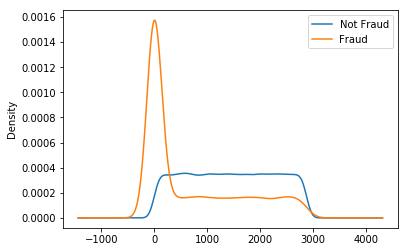

In [22]:
### Investigate the difference between signup and purchase date for two classes
def calculate_time_latency(df):
    '''Calculates the difference between sign up and purchase times'''
    df['time_latency'] = (df.purchase_time - df.signup_time).dt.total_seconds()/60/60
    return df
latency_df = calculate_time_latency(analysis_df)
latency_df.groupby('class').time_latency.plot(kind = 'kde', legend = True);
plt.legend(['Not Fraud', 'Fraud'])

In [23]:
from functools import reduce
def merge_multiple_dataframes(dfs, key, method):
    return reduce(lambda  left, right: pd.merge(left, right, on = key, how=method), dfs)

In [24]:
feature_df = merge_multiple_dataframes([
                                        fraud_by_dev.drop('class', axis = 1), 
                                        fraud_by_country.drop('class', axis = 1), 
                                        fraud_by_gender.drop('class', axis = 1), 
                                        fraud_by_age.drop('class', axis = 1), 
                                        fraud_by_browser.drop('class', axis = 1), 
                                        fraud_by_source.drop('class', axis = 1), 
                                        analysis_df[['user_id', 'purchase_value', 'class']],
                                        latency_df[['user_id', 'time_latency']]
                                       ], 
                                       key = ['user_id'], method = 'outer')
feature_df.head()

,user_id,device_id,ratio_fraud_device_id,num_trans_device_id,country,ratio_fraud_country,num_trans_country,sex,ratio_fraud_sex,num_trans_sex,...,num_trans_age,browser,ratio_fraud_browser,num_trans_browser,source,ratio_fraud_source,num_trans_source,purchase_value,class,time_latency
0,285108,HZAKVUFTDOSFD,0.0,2.0,United States,0.096830,46184.0,M,0.095442,70126,...,1079.0,Chrome,0.099441,48652,Direct,0.105643,24242,31,0,1377.683333
1,369076,HZAKVUFTDOSFD,0.0,2.0,Canada,0.115188,2344.0,M,0.095442,70126,...,2686.0,Safari,0.091743,19620,Ads,0.091696,47461,40,0,1372.683333
2,131009,XGQAJSOUJIZCC,0.0,1.0,United Kingdom,0.103911,3580.0,F,0.091671,49874,...,2989.0,IE,0.086107,29138,SEO,0.090109,48297,31,0,1888.400000
3,328855,VCCTAYDCWKZIY,0.0,1.0,United States,0.096830,46184.0,M,0.095442,70126,...,4460.0,IE,0.086107,29138,Direct,0.105643,24242,16,0,611.483333
4,229053,MFFIHYNXCJLEY,0.0,1.0,Korea Republic of,0.091589,3341.0,M,0.095442,70126,...,5006.0,Chrome,0.099441,48652,SEO,0.090109,48297,29,0,44.883333


In [ ]:
sel_feature_df = feature_df.set_index(['user_id', 'device_id', 'country', 'sex', 'age', 'browser', 'source'])